In [1]:
import pandas as pd
import time

In [2]:
# def execution_time(func):
#     def wrapper(*args, **kwargs):
#         start_time = time.time()
#         result = func(*args, **kwargs)
#         end_time = time.time()
#         execution_time = end_time - start_time
#         print(f"Function '{func.__name__}' executed in {execution_time:.6f} seconds")
#         return result
#     return wrapper

In [3]:
list_of_files = [
    "files/PEX_Actual_Master_DE01_2090_12_2023.xlsm",
    "files/PEX_Actual_Master_DE01_2090_12_2024.xlsm",
    "files/PEX_Actual_Master_DE01_2090_05_2025.xlsm"
    ]

str_unit = "DE01"

In [4]:
# Takes approx 6 mins to execute, run only if the file is missing or if you wants to do re-run

df = pd.DataFrame()
for file in list_of_files:
    data = pd.read_excel(
        file, 
        sheet_name="KSB1", 
        usecols=["Cost Element", "Cost element name", "Cost Center", "CO object name", "Fiscal Year", "From Period","To Period","Posting Date", "Value in Obj. Crcy", "Object Currency", "Object Group name"]
    )
    data["Unit Name"] = str_unit
    data = data[["Cost Element", "Cost element name", "Cost Center", "CO object name", "Fiscal Year", "From Period","To Period","Posting Date", "Value in Obj. Crcy", "Object Currency", "Object Group name"]]
    data["Posting Date"] = pd.to_datetime(data["Posting Date"])
    data["Week Number"] = data["Posting Date"].dt.isocalendar().week
    data["Key"] = data["Cost Element"].astype(str) + "_" + data["CO object name"].astype(str)
    df = pd.concat([df, data], ignore_index=True)

df.to_csv("Pex_Merged.csv", index=False)
    

In [5]:
df = pd.read_csv("Pex_Merged.csv")
df.shape

(1544846, 13)

In [6]:
min(df["Posting Date"]), max(df["Posting Date"])

('2023-01-01', '2025-05-17')

In [7]:
# remove data from 1st april 2025
df = df[df["Posting Date"] < "2025-04-01"]
df.to_csv("PEX_Filtered.csv", index=False) 
df.shape

(1457562, 13)

In [8]:
# data after removing 1st april 2025 onwards data
min(df["Posting Date"]), max(df["Posting Date"])

('2023-01-01', '2025-03-31')

In [9]:
df.head()

,Cost Element,Cost element name,Cost Center,CO object name,Fiscal Year,From Period,To Period,Posting Date,Value in Obj. Crcy,Object Currency,Object Group name,Week Number,Key
0,7299050,Non Office Equipment,209040003,Logistics,2023,1,1,2023-01-02,367.80,EUR,Logistics and Purchasing Costs,1,7299050_Logistics
1,9430410,Service Labor,209050045,OSV West / Service Labor,2023,1,1,2023-01-02,88.16,EUR,Service,1,9430410_OSV West / Service Labor
2,9430410,Service Labor,209050045,OSV West / Service Labor,2023,1,1,2023-01-02,-88.16,EUR,Service,1,9430410_OSV West / Service Labor
3,9430410,Service Labor,209050045,OSV West / Service Labor,2023,1,1,2023-01-02,129.92,EUR,Service,1,9430410_OSV West / Service Labor
4,9430410,Service Labor,209050045,OSV West / Service Labor,2023,1,1,2023-01-02,-129.92,EUR,Service,1,9430410_OSV West / Service Labor


In [10]:
# grouped the amount if there are similar rows for the differnent amount
grouped_df = df.groupby(
    ["Cost Element", "Cost element name", "Cost Center", "CO object name", "Fiscal Year", "From Period","To Period","Posting Date", "Object Currency", "Object Group name", "Week Number","Key"]
).agg({"Value in Obj. Crcy": "sum"}).reset_index()
grouped_df.shape
grouped_df.to_csv("PEX_Grouped.csv", index=False)

In [11]:
grouped_df["postingkey"] = grouped_df["Cost Element"].astype(str) + "_" + grouped_df["Cost Center"].astype(str) + "_" + grouped_df["Key"].astype(str) + "_" + grouped_df["Posting Date"].astype(str)

# # Group by the columns you want to pivot on and aggregate the 'Value in Obj. Crcy' column
# grouped_data = df.groupby(["Posting Date", "Cost Center", "Key", "Week Number"]).agg({"Value in Obj. Crcy": "sum"}).reset_index()
# print(grouped_data.head())
# # Pivot the data
pivoted_data = grouped_df.pivot(index="postingkey", columns="Key", values="Value in Obj. Crcy")

total_sales_df = pivoted_data
total_sales_df.head()

Key,7000090_SI Fremdleistung S,7000090_Team RET,7000160_OSV OVH,7000160_OnSite PIP,7000290_AC Fremdleistung S,7000290_ANA Fremdleistung P,7000290_ANA Fremdleistung S,7000290_Bentomax GmbH,7000290_Building,7000290_CS Bürotechnik,...,9430420_OSV Zentral / Service Travel Labor,9430420_Pre & After Sales / Service Travel Labor,9430420_RET CE / Disp. / Sup / Service Travel Labor,9430420_RET SVC Product Mgmt / Service Travel Labor,9430420_RET SVC Project Mgmt / Service Travel Labor,9430420_RET Service / Service Travel Labor,9430420_RET SubCo Management / Service Travel Labor,9430420_SVC Proj. / PRD Mngm / Service Travel Labor,9430420_Service Fieldsales / Service Travel Labor,9430420_Software / Service Travel Labor
postingkey,,,,,,,,,,,,,,,,,,,,,
7000090_209010011_7000090_SI Fremdleistung S_2025-02-12,-200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7000090_209070002_7000090_Team RET_2023-08-31,NaN,1671.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7000090_209070002_7000090_Team RET_2023-09-26,NaN,-7.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7000090_209070002_7000090_Team RET_2023-10-04,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7000160_209050022_7000160_OnSite PIP_2023-08-08,NaN,NaN,NaN,-1997.96,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
import matplotlib.pyplot as plt

In [14]:
# for column in total_sales_df.columns:
#     print(f"Plotting {column}")
#     plt.plot(total_sales_df.index, total_sales_df[column], label=column)
#     plt.title(column)
#     plt.show()

In [15]:
def visualize_weekly_data(data, year):
    filtered_data = data[data["Fiscal Year"] == year]
    
    # Group by week and sum the values
    weekly_data = filtered_data.groupby("Week Number")["Value in Obj. Crcy"].sum().reset_index()
    
    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(weekly_data["Week Number"], weekly_data["Value in Obj. Crcy"], marker="o", label=f"Year {year}")
    plt.title(f"Weekly Expenses for Year {year}")
    plt.xlabel("Week Number")
    plt.ylabel("Amount (Value in Obj. Crcy)")
    plt.xticks(range(1, 53, 2))  # Show every 2nd week for better readability
    plt.grid(True)
    plt.legend()
    plt.show()

combined_data = pd.read_csv("Pex_Merged.csv", parse_dates=["Posting Date"])

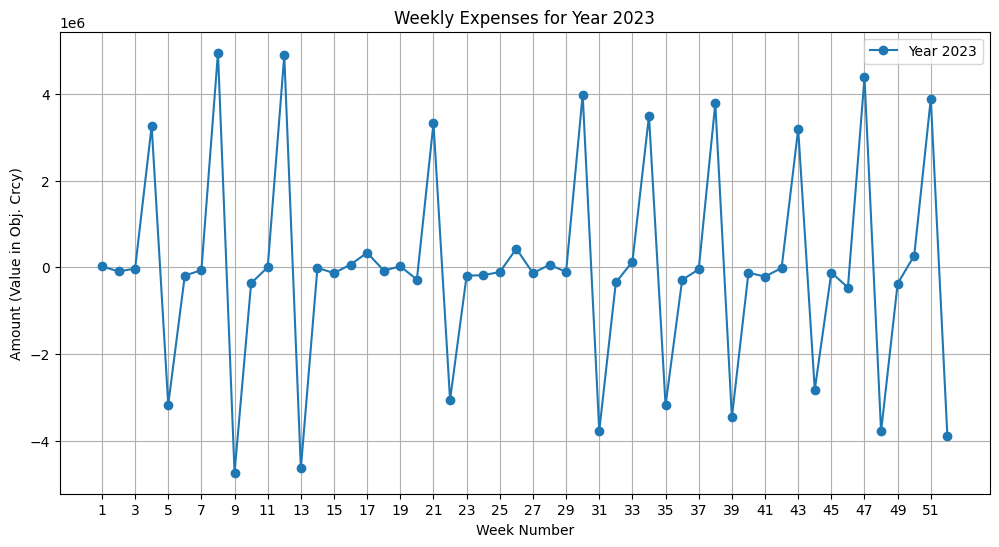

In [16]:
visualize_weekly_data(df, year=2023)

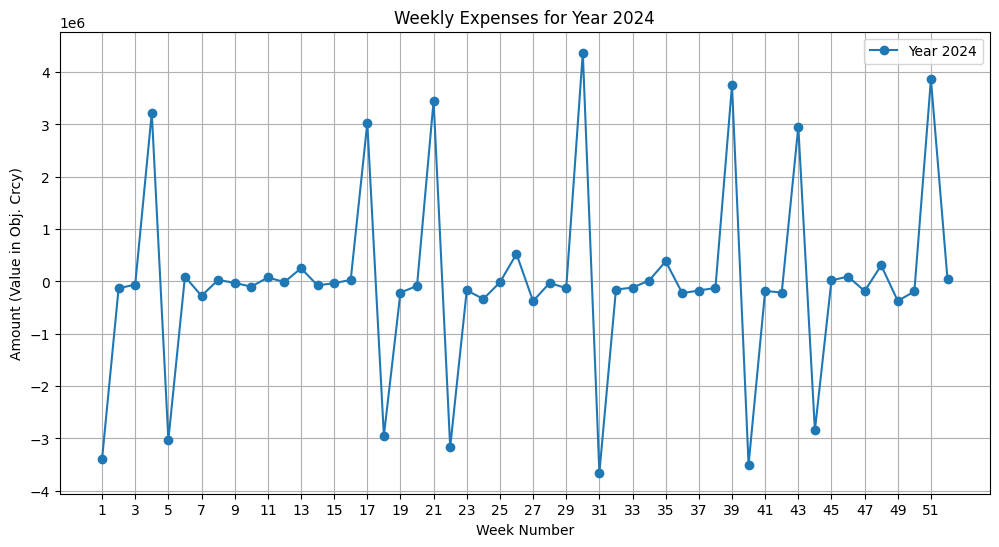

In [17]:
visualize_weekly_data(df, year=2024)

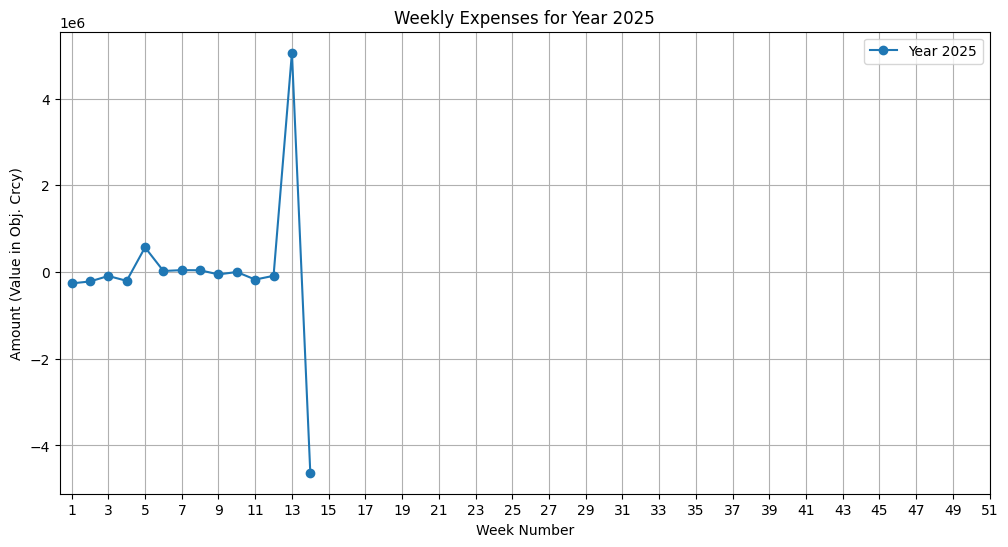

In [18]:
visualize_weekly_data(df, year=2025)